# Training a model using Synthetic Data

In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import tensorflow as tf
import numpy as np
import os
import time
from datetime import datetime
from six.moves import cPickle as pickle

Loading Synthethic data

In [2]:
file_name = 'Synthetic_data/SyntheticData32.pickle'
with open(file_name, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save

valid_dataset = valid_dataset[:3000]
valid_labels = valid_labels[:3000]
test_dataset = test_dataset[:10000]
test_labels = test_labels[:10000]
print(train_dataset.shape, train_labels.shape)
print(test_dataset.shape, test_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

(160000, 32, 32, 1) (160000, 6)
(10000, 32, 32, 1) (10000, 6)
(3000, 32, 32, 1) (3000, 6)


In [3]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [4]:
image_size = 32
num_labels = 11  # 0-9, + blank 
num_channels = 1 # grayscale
num_digits = 5

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
num_hidden2 = 64

graph = tf.Graph()
with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_digits+1))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

    # Sequence length
    ss_w = tf.get_variable("WSS", shape=[num_hidden2, num_digits + 1],\
                           initializer=tf.contrib.layers.xavier_initializer())
    ss_b = tf.Variable(tf.constant(1.0, shape=[num_digits+1]), name='BSS')
    
    # Digits
    s1_w = tf.get_variable("WS1", shape=[num_hidden2, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
    s2_w = tf.get_variable("WS2", shape=[num_hidden2, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
    s3_w = tf.get_variable("WS3", shape=[num_hidden2, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')   
    s4_w = tf.get_variable("WS4", shape=[num_hidden2, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4') 
    s5_w = tf.get_variable("WS5", shape=[num_hidden2, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS5') 
    
    # Model.
    def model(data, keep_prob):
        conv = tf.nn.conv2d(data, layer1_weights, [1,1,1,1], 'VALID', name='C1')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S1')
        
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C2')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
        
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

        logits0 = tf.matmul(reshape, ss_w) + ss_b
        # This concat only allow us to have a one hot vector like the others (to pack the results in the following lines)
        logits0 = tf.concat(1, [logits0, tf.zeros([shape[0],5])])
        logits1 = tf.matmul(reshape, s1_w) + s1_b
        logits2 = tf.matmul(reshape, s2_w) + s2_b
        logits3 = tf.matmul(reshape, s3_w) + s3_b
        logits4 = tf.matmul(reshape, s4_w) + s4_b
        logits5 = tf.matmul(reshape, s5_w) + s5_b
        return [logits0, logits1, logits2, logits3, logits4, logits5]
    
    # Training computation.
    [logits0, logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.975)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits0, tf_train_labels[:,0])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
        
    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.04, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #optimizer = tf.train.MomentumOptimizer(learning_rate,0.9).minimize(loss, global_step=global_step)
    
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0)[0]),\
                                tf.nn.softmax(model(tf_train_dataset, 1.0)[1]),\
                                tf.nn.softmax(model(tf_train_dataset, 1.0)[2]),\
                                tf.nn.softmax(model(tf_train_dataset, 1.0)[3]),\
                                tf.nn.softmax(model(tf_train_dataset, 1.0)[4]),\
                                tf.nn.softmax(model(tf_train_dataset, 1.0)[5])])
    valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0)[0]),\
                                tf.nn.softmax(model(tf_valid_dataset, 1.0)[1]),\
                                tf.nn.softmax(model(tf_valid_dataset, 1.0)[2]),\
                                tf.nn.softmax(model(tf_valid_dataset, 1.0)[3]),\
                                tf.nn.softmax(model(tf_valid_dataset, 1.0)[4]),\
                                tf.nn.softmax(model(tf_valid_dataset, 1.0)[5])])
    test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0)[0]),\
                                tf.nn.softmax(model(tf_test_dataset, 1.0)[1]),\
                                tf.nn.softmax(model(tf_test_dataset, 1.0)[2]),\
                                tf.nn.softmax(model(tf_test_dataset, 1.0)[3]),\
                                tf.nn.softmax(model(tf_test_dataset, 1.0)[4]),\
                                tf.nn.softmax(model(tf_test_dataset, 1.0)[5])])
    
    saver = tf.train.Saver()

In [ ]:
# For visualization
acc_synthetic_batch = []
acc_synthetic_valid = []

acc_SVHN_batch = []
acc_SVHN_valid = []

In [5]:
filename = "Models/Synthetic_Model.ckpt"
num_steps = 20000

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()  
    
    if os.path.exists(filename):
        reader = tf.train.NewCheckpointReader(filename)
        reader.get_variable_to_shape_map()
        saver.restore(session, filename)
        print('Model restored.')
    print('Initialized')
  
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0): 
            acc_batch = accuracy(predictions, batch_labels[:,0:])
            acc_valid = accuracy(valid_prediction.eval(), valid_labels[:,0:])
            acc_synthetic_batch.append(acc_batch)
            acc_synthetic_valid.append(acc_valid)
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % acc_batch)
            print('Validation accuracy: %.1f%%' % acc_valid)
            
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,0:]))
    save_path = saver.save(session, filename)
    print("Model saved in file: %s" % save_path)    

Initialized
Minibatch loss at step 0: 17.129694
Minibatch accuracy: 20.3%
Validation accuracy: 38.8%
Minibatch loss at step 500: 5.888487
Minibatch accuracy: 63.8%
Validation accuracy: 63.4%
Minibatch loss at step 1000: 6.148942
Minibatch accuracy: 62.8%
Validation accuracy: 65.9%
Minibatch loss at step 1500: 4.570237
Minibatch accuracy: 76.0%
Validation accuracy: 70.4%
Minibatch loss at step 2000: 5.593374
Minibatch accuracy: 65.9%
Validation accuracy: 73.8%
Minibatch loss at step 2500: 4.552387
Minibatch accuracy: 74.0%
Validation accuracy: 76.7%
Minibatch loss at step 3000: 3.234842
Minibatch accuracy: 80.7%
Validation accuracy: 78.1%
Minibatch loss at step 3500: 3.285993
Minibatch accuracy: 79.2%
Validation accuracy: 79.1%
Minibatch loss at step 4000: 3.306557
Minibatch accuracy: 81.0%
Validation accuracy: 80.2%
Minibatch loss at step 4500: 3.408890
Minibatch accuracy: 83.3%
Validation accuracy: 81.0%
Minibatch loss at step 5000: 2.910397
Minibatch accuracy: 85.4%
Validation accura

## Performance on Testing set

Selecting 10 random images

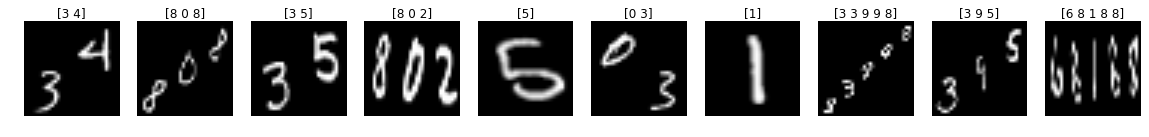

In [10]:
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
    
for i,j in enumerate(np.sort(np.random.randint(0, test_labels.shape[0], size = 10))):
    im_samples.extend([j])
    ax[i].axis('off')
    label = test_labels[j,1:1+test_labels[j,0]]
    ax[i].set_title(label, loc='center')
    ax[i].imshow(test_dataset[j,:,:,0],cmap="gray")


# Training and evaluation this architecture using SVHN datasets

This will require the files generated after executing "3_Preprocess_SVHN.ipynb"

## Load data from binaries

In [6]:
# This function reads one record from the binary files
def read_binary(filename_queue):
    label_bytes = 6     # Labels contain: Number of digits + 5 digits
    img_height = 64
    img_width = 64
    img_channels = 3
    image_bytes = img_height * img_width * img_channels
    
    # Every record consists of a label followed by the image, with a fixed number of bytes for each.
    record_bytes = label_bytes + image_bytes
    reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
    key, value = reader.read(filename_queue)
    record_bytes = tf.decode_raw(value, tf.int8)

    label = tf.cast(tf.slice(record_bytes, [0], [label_bytes]),tf.int32)
    image = tf.cast(tf.reshape(tf.slice(record_bytes, [label_bytes], [image_bytes]),[img_height, img_width, img_channels]), tf.float32)
    
    # This is the size of the crops 
    height = 54
    width = 54

    # Randomly crop a [height, width] section of the image.
    image = tf.random_crop(image, [height, width, 3])
    
    # Resize to network input
    image = tf.image.resize_images(image, 32,32)
    # To gray scale
    image = tf.image.rgb_to_grayscale(image)
    
    # Apply random brightness/contrast transformations
    if (np.random.random_sample()>0.5):
        image = tf.image.random_brightness(image, max_delta=63)
        image = tf.image.random_contrast(image,lower=0.2, upper=1.8)
    else:
        image = tf.image.random_contrast(image,lower=0.2, upper=1.8)
        image = tf.image.random_brightness(image, max_delta=63)
    
    # Subtract mean
    image = tf.sub(image, tf.reduce_mean(image))

    return image, label   

# This function create training batches running processes in parallel
def input_pipeline(filenames, batch_size, num_epochs=None):
    num_preprocess_threads = 2
    
    filename_queue = tf.train.string_input_producer(filenames, num_epochs=num_epochs, shuffle=True)
    example_list = [read_binary(filename_queue) for _ in range(num_preprocess_threads)]

    label, image = read_binary(filename_queue)
    min_after_dequeue = 2000
    capacity = min_after_dequeue + 3 * batch_size

    image_batch, label_batch = tf.train.shuffle_batch_join(
        example_list, batch_size=batch_size, capacity=capacity,
        min_after_dequeue=min_after_dequeue)

    return image_batch, label_batch

## Load validation/testing from pickle

In [7]:
def load_valid_test(num_valid, num_test, filename):
    with open(filename, 'rb') as f:
        save = pickle.load(f)
        valid_dataset = save['valid_dataset']
        valid_labels = save['valid_labels']
        test_dataset = save['test_dataset']
        test_labels = save['test_labels']
        del save
    
    height = 54
    width = 54
    for i in range(num_valid):
        temp = tf.cast(tf.constant(valid_dataset[i,:,:,:]),tf.float32)
        # Randomly crop a [height, width] section of the image.
        temp = tf.random_crop(temp, [height, width, 3])  
        # Resize to network input
        temp = tf.image.resize_images(temp, 32,32)
        # To gray scale
        temp = tf.image.rgb_to_grayscale(temp)    
        # Subtract mean
        temp = tf.sub(temp, tf.reduce_mean(temp))
        if i==0:
            result = tf.expand_dims(temp, 0)
        else:
            result = tf.concat(0, [result, tf.expand_dims(temp, 0)])

    valid_dataset = result
    valid_labels = tf.cast(valid_labels[:num_valid],tf.int32)
    
    for i in range(num_test):
        temp = tf.cast(tf.constant(test_dataset[i,:,:,:]),tf.float32)
        # Randomly crop a [height, width] section of the image.
        temp = tf.random_crop(temp, [height, width, 3]) 
        # Resize to network input
        temp = tf.image.resize_images(temp, 32,32)
        # To gray scale
        temp = tf.image.rgb_to_grayscale(temp)    
        # Subtract mean
        temp = tf.sub(temp, tf.reduce_mean(temp))
        if i==0:
            result = tf.expand_dims(temp, 0)
        else:
            result = tf.concat(0, [result, tf.expand_dims(temp, 0)])

    test_dataset = result
    test_labels = tf.cast(test_labels[:num_test],tf.float32)
    
    return valid_dataset, valid_labels, test_dataset, test_labels

## Define network architecture

Same architecture but it now loads the training data from binary files

In [8]:
image_size = 32
num_labels = 11  # 0-9, + blank 
num_channels = 1 # grayscale
num_digits = 5

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
num_hidden2 = 64

# Binary files where the training data was stored
file_names = [os.path.join('SVHN_data/','Train%d_64.bin' % i) for i in range(1,4)]
# Pickle file where validation and testing were stored
valid_test_file_name = 'SVHN_data/SVHN64.pickle'
# Number of Valid/Testing samples to load into memory
num_valid = 1000
num_test = 2000

graph = tf.Graph()
with graph.as_default():
    # Input data.
    tf_train_dataset, tf_train_labels = input_pipeline(file_names, batch_size, num_epochs=None)   
    tf_valid_dataset, tf_valid_labels, tf_test_dataset, tf_test_labels = load_valid_test(num_valid, num_test, valid_test_file_name)
    
    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

    # Sequence length
    ss_w = tf.get_variable("WSS", shape=[num_hidden2, num_digits + 1],\
                           initializer=tf.contrib.layers.xavier_initializer())
    ss_b = tf.Variable(tf.constant(1.0, shape=[num_digits+1]), name='BSS')
    
    # Digits
    s1_w = tf.get_variable("WS1", shape=[num_hidden2, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
    s2_w = tf.get_variable("WS2", shape=[num_hidden2, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
    s3_w = tf.get_variable("WS3", shape=[num_hidden2, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')   
    s4_w = tf.get_variable("WS4", shape=[num_hidden2, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4') 
    s5_w = tf.get_variable("WS5", shape=[num_hidden2, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS5') 
    
    # Model.
    def model(data, keep_prob):
        conv = tf.nn.conv2d(data, layer1_weights, [1,1,1,1], 'VALID', name='C1')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S1')
        
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C2')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
        
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

        logits0 = tf.matmul(reshape, ss_w) + ss_b
        # This concat only allow us to have a one hot vector like the others (to pack the results in the following lines)
        logits0 = tf.concat(1, [logits0, tf.zeros([shape[0],5])])
        logits1 = tf.matmul(reshape, s1_w) + s1_b
        logits2 = tf.matmul(reshape, s2_w) + s2_b
        logits3 = tf.matmul(reshape, s3_w) + s3_b
        logits4 = tf.matmul(reshape, s4_w) + s4_b
        logits5 = tf.matmul(reshape, s5_w) + s5_b
        return [logits0, logits1, logits2, logits3, logits4, logits5]
    
    # Training computation.
    [logits0, logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.975)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits0, tf_train_labels[:,0])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
        
    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.04, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #optimizer = tf.train.MomentumOptimizer(learning_rate,0.9).minimize(loss, global_step=global_step)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0)[0]),\
                                tf.nn.softmax(model(tf_train_dataset, 1.0)[1]),\
                                tf.nn.softmax(model(tf_train_dataset, 1.0)[2]),\
                                tf.nn.softmax(model(tf_train_dataset, 1.0)[3]),\
                                tf.nn.softmax(model(tf_train_dataset, 1.0)[4]),\
                                tf.nn.softmax(model(tf_train_dataset, 1.0)[5])])
    valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0)[0]),\
                                tf.nn.softmax(model(tf_valid_dataset, 1.0)[1]),\
                                tf.nn.softmax(model(tf_valid_dataset, 1.0)[2]),\
                                tf.nn.softmax(model(tf_valid_dataset, 1.0)[3]),\
                                tf.nn.softmax(model(tf_valid_dataset, 1.0)[4]),\
                                tf.nn.softmax(model(tf_valid_dataset, 1.0)[5])])
    test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0)[0]),\
                                tf.nn.softmax(model(tf_test_dataset, 1.0)[1]),\
                                tf.nn.softmax(model(tf_test_dataset, 1.0)[2]),\
                                tf.nn.softmax(model(tf_test_dataset, 1.0)[3]),\
                                tf.nn.softmax(model(tf_test_dataset, 1.0)[4]),\
                                tf.nn.softmax(model(tf_test_dataset, 1.0)[5])])
    
    saver = tf.train.Saver()

In [9]:
filename = "Models/Synthetic_Model_SVHN.ckpt"
num_steps = 20000

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()  
    
    # These are required to start the processes reading training batches
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=session, coord=coord)
    
    if os.path.exists(filename):
        reader = tf.train.NewCheckpointReader(filename)
        reader.get_variable_to_shape_map()
        saver.restore(session, filename)
        print('Model restored.')
    print('Initialized')
  
    for step in range(num_steps):   
        _, l,  = session.run([optimizer, loss])

        if (step % 500 == 0): 
            batch_predictions, batch_labels, valid_label = session.run([train_prediction, tf_train_labels, tf_valid_labels])   
            acc_batch = accuracy(batch_predictions, batch_labels[:,0:])
            acc_valid = accuracy(valid_prediction.eval(), valid_label[:,0:])
            acc_SVHN_batch.append(acc_batch)
            acc_SVHN_valid.append(acc_valid)
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % acc_batch)
            print('Validation accuracy: %.1f%%' % acc_valid) 

    test_dataset, labels_test, prediction_test = session.run([tf_test_dataset, tf_test_labels, test_prediction])
    # Accuracy on testing set
    print('Test accuracy: %.1f%%' % accuracy(prediction_test, labels_test[:,0:]))    

    save_path = saver.save(session, filename)
    print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 20.405554
Minibatch accuracy: 43.8%
Validation accuracy: 42.2%
Minibatch loss at step 500: 7.099613
Minibatch accuracy: 60.9%
Validation accuracy: 59.6%
Minibatch loss at step 1000: 6.144541
Minibatch accuracy: 62.8%
Validation accuracy: 61.6%
Minibatch loss at step 1500: 6.607010
Minibatch accuracy: 64.6%
Validation accuracy: 60.3%
Minibatch loss at step 2000: 6.106441
Minibatch accuracy: 59.9%
Validation accuracy: 65.4%
Minibatch loss at step 2500: 6.356358
Minibatch accuracy: 64.8%
Validation accuracy: 64.2%
Minibatch loss at step 3000: 6.186196
Minibatch accuracy: 68.8%
Validation accuracy: 66.1%
Minibatch loss at step 3500: 5.962085
Minibatch accuracy: 69.0%
Validation accuracy: 62.9%
Minibatch loss at step 4000: 5.373891
Minibatch accuracy: 68.5%
Validation accuracy: 63.0%
Minibatch loss at step 4500: 6.036961
Minibatch accuracy: 67.2%
Validation accuracy: 65.9%
Minibatch loss at step 5000: 6.064417
Minibatch accuracy: 60.4%
Validation accura

## Comparing the performance 

Comparing performance on Synthetic and SVHN datasets

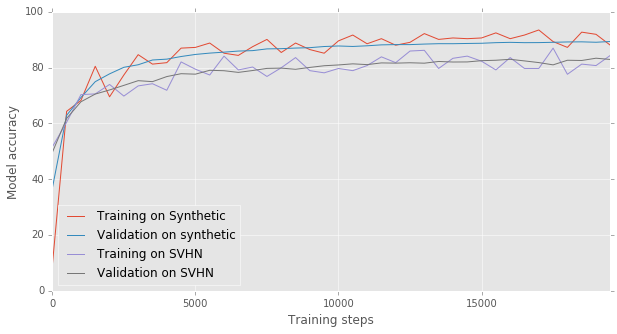

In [21]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

data = np.column_stack((acc_synthetic_batch, acc_synthetic_valid, acc_SVHN_batch, acc_SVHN_valid))
df1 = pd.DataFrame(data, index = np.arange(0,20000,500), columns=['Training on Synthetic', 'Validation on synthetic', 'Training on SVHN', 'Validation on SVHN'])
df1.index.name = 'Training steps'
f = plt.figure(1, figsize = (10,5))
ax = df1.plot(ax=f.gca())
ax.set_ylabel("Model accuracy")
axes = plt.gca()
plt.show()

In [12]:
# These are previously saved performance values using 3 different optimization methods
file_name1 = 'assets/Accuracy_Momentum.pickle'
file_name2 = 'assets/Accuracy_RMS.pickle'
file_name3 = 'assets/Accuracy_Adagrad.pickle'
with open(file_name1, 'rb') as f:
    save = pickle.load(f)
    data_Momentum = save['data_acc']
    del save
with open(file_name2, 'rb') as f:
    save = pickle.load(f)
    data_RMS = save['data_acc']
    del save
with open(file_name3, 'rb') as f:
    save = pickle.load(f)
    data_Adagrad = save['data_acc']
    del save

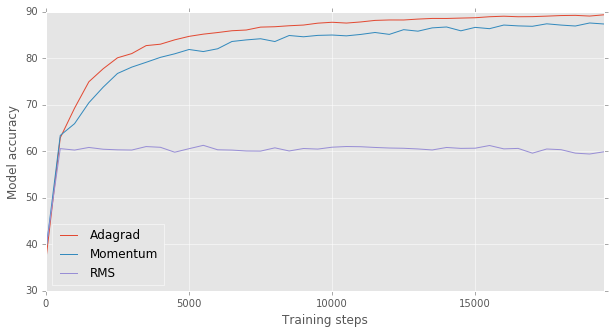

In [18]:
data_compare = np.column_stack((data_Adagrad[:,1], data_Momentum[:,1], data_RMS[:,1]))
df2 = pd.DataFrame(data_compare, index = np.arange(0,20000,500), columns=['Adagrad', 'Momentum', 'RMS'])
df2.index.name = 'Training steps'
f = plt.figure(1, figsize = (10,5))
#plt.title('Number of digits in the different dataset images (%)', color='black')
ax = df2.plot(ax=f.gca())
ax.set_ylabel("Model accuracy")
axes = plt.gca()
plt.show()